<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install pymorphy2 --quiet

In [87]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [88]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
data.sample(10)

,comment,toxic
9243,"Я конечно дико извиняюсь, но всё-таки, а что с...",0.0
13001,Ну эти криветосы очень большие когда вырастают...,0.0
9692,"неядовитых паучков Покажи мне, блять, хоть одн...",1.0
2525,удачи жирным старым бабам пёздов выделения язы...,1.0
5534,Сейчас если по уму надо этих школьников отпизд...,1.0
6043,Хохлы как всегда приезжают со своего хутора в ...,1.0
8812,"Ну регион, стало быть\n",0.0
12029,"У нас в городе в синема парке 2 сеанса, 22.30 ...",0.0
5619,"незнаю блять, я на хроме такого не ставил, обы...",0.0
8416,"Да небось в танки гонял, пукан полыхнул и улет...",1.0


In [89]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


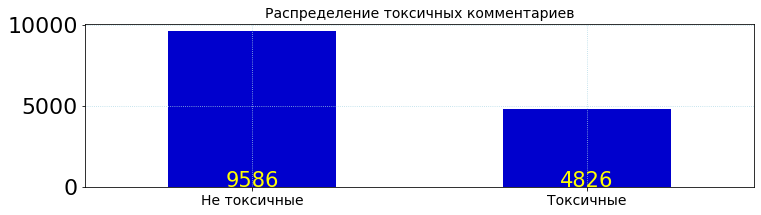

In [90]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [91]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [92]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [93]:
def clear_and_lemmatize_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [94]:
%%time
data['comment'] = data['comment'].apply(clear_and_lemmatize_text)

CPU times: user 1min 20s, sys: 257 ms, total: 1min 20s
Wall time: 1min 20s


In [95]:
data.sample(10)

,comment,toxic
8336,странно ранний казаться такой бедный страна ти...,0.0
4739,в двор не парковка штраф космический треть сто...,0.0
301,что то такой идиот защищать всякий непотребств...,1.0
10310,предположение не возражение наука на такой мак...,0.0
7609,хм думать что никто не думать что программист ...,0.0
11145,а при чем тут сложный характер случай тс вовсе...,0.0
12101,спасибо за информация прошлое лето по грузия к...,0.0
9185,а б хотеть каждый день пить но проклятый токси...,1.0
5937,ага публично на колено отсосать они по очередь,1.0
5607,это вс хорошо но страна уа контора уровень фбк...,0.0


In [96]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [97]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv')
df.sample(10)

,comment,toxic
3003,конч долоб они словечко сосать хуй ебал твой м...,1
10204,однако интересно как концовка многомерный всел...,0
13501,можно что то нахимичить акция например роздава...,0
4192,переключение между поле ввод кнопка прочий инт...,0
5668,он стать популярный только после тот как он де...,1
1131,уж не заниматься ли братец торговля специально...,0
4163,очень мило ребёночек самый оно чтобы играть,0
12411,интересно сколько человек за такой прикол мост...,0
6286,как думать каков шанс что свидетельство весь э...,0
1256,это весьма простой электромеханический система...,0


**Взвесим tf-idf**

In [98]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [99]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [100]:
neutral_importance.sample(10) 

,word,idf
5643,разрешение,7.395575
732,ворота,8.558725
4483,пластиковый,7.223724
4865,попросту,8.558725
4552,повсюду,8.376404
5419,простой,5.056176
2501,конкретика,8.558725
1715,завязать,8.376404
5520,пучение,8.781869
3003,мелкий,6.160830


In [101]:
toxic_importance.sample(10)

,word,idf
3518,срач,7.179395
2704,порядок,6.648767
1368,конец,6.080783
1881,настроение,7.536070
2095,обсуждение,6.773930
1162,игрушка,8.095686
2206,орнуть,8.095686
664,группа,6.346486
2721,посон,7.690221
2961,проходить,7.179395


**Разделение выборок, преобразование текстов**

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [103]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [104]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [105]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [106]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 87.37 %


In [107]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

In [108]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 

True Negatives:  1832
False Positives:  70
False Negatives:  294
True Positives:  687


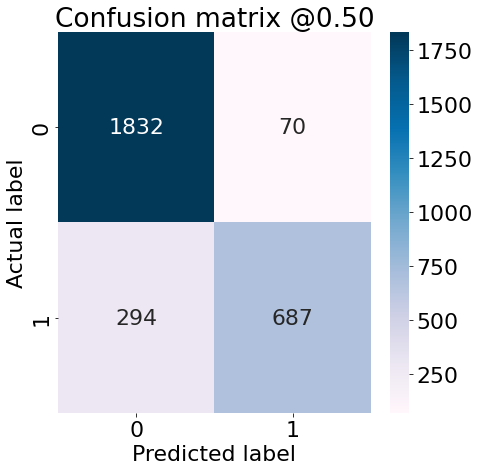

In [109]:
plot_cm(y_test, pred)

In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1902
           1       0.91      0.70      0.79       981

    accuracy                           0.87      2883
   macro avg       0.88      0.83      0.85      2883
weighted avg       0.88      0.87      0.87      2883



**Отобразим ROC - кривую**

LogisticRegression: ROC AUC=0.938


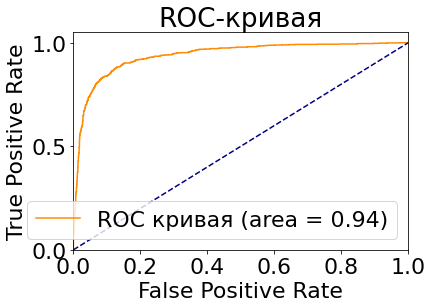

In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = clf.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [112]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [113]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

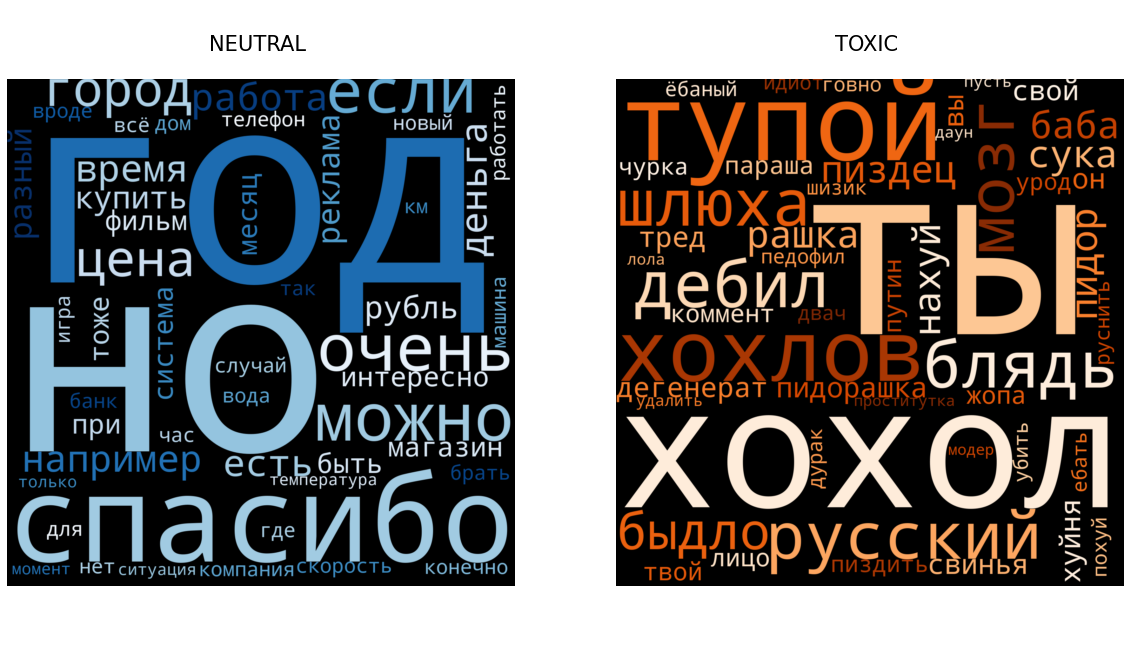

In [114]:
wordplot(toxic, neutral)